In [11]:
from activity_1 import variance, arithmetic_average
from activity_2 import confidence_interval
from math import sqrt, fabs
from random import expovariate
import numpy as np
from queue import Queue
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

%matplotlib inline

In [12]:
def get_mean_waiting_theoric(lambda_, mi, is_m=True, K=1):
    ro = lambda_ / mi
    
    if is_m:
        return ro / (mi * (1 - ro))
    
    else:
        numerator = ro * (1 + (1 / K))
        denominator = 2 * mi * (1 - ro)
        
        return numerator / denominator

In [13]:
def get_contains_percent_value(turns, theoric_value):
    total = len(turns)
    partial = 0
    
    for turn in turns:
        min_value, max_value = turn['confidence_interval']
        if min_value <= theoric_value <= max_value:
            partial += 1
            
    return partial / total

In [65]:
def nbm(data, B=20):
    def get_r_bar(mean_buckets, B):
        comb_mean_buckets = list(combinations_with_replacement(mean_buckets, r=2))
        count = [
            1 
            for mean_buckets
            in comb_mean_buckets
            if mean_buckets[0] != mean_buckets[1]
            and mean_buckets[1] <= mean_buckets[0]
        ]
        
        return sum(count) / B
        
    beta = 1.29 # n = 20 and alpha = 0.05
    M = len(data) // B
    
    mean_buckets = [
        arithmetic_average(data[i : i+M])
        for i
        in range(0, len(data), M)
    ]
    r_bar = get_r_bar(mean_buckets, B)
    
    
    numerator = sum([
        (mean_buckets[i] - mean_buckets[i+1])**2
        for i
        in range(len(mean_buckets)-1)
    ])
    denominator = sum([
        (mean_buckets[i] - r_bar)**2
        for i
        in range(len(mean_buckets)-1)
    ])
    
    rvn = numerator / denominator
    
    return False if rvn <= beta else True

In [66]:
def mser(data, n=5):
    data_size = len(data)
    K = data_size // n
    
    z_values = [
        arithmetic_average(data[i : i+n])
        for i
        in range(0, data_size, n)
    ]
    
    d_values = []
    for d in range(K//2):
        mser_5y = variance(z_values[d:]) / sqrt(K - d)
        d_values.append(mser_5y)
        
    d = d_values.index(min(d_values))
    #print(f'The first {n * d} elements have been removed')
    #print(f'{data_size - (n * d)} elements left')
    
    return data[d * n:]

In [67]:
def simulate_queue(lambda_, mi, n):
    time_arrival = 1 / lambda_
    time_attendance = 1 / mi
    clock_current = 0
    queue = Queue()
    times_waiting = []
    
    for i in range(n):
        exp_arrival = np.random.exponential(time_arrival)
        exp_attendance = np.random.exponential(time_attendance)
        
        if queue.empty():
            clock_current += exp_arrival
            queue.put(clock_current)
            
        else:
            clock_simulation = clock_current
            
            while clock_current < clock_simulation + exp_arrival and not queue.empty():
                time_waiting = clock_current - queue.get()
                clock_current += exp_attendance
                times_waiting.append(time_waiting)

            if clock_current < clock_simulation + exp_arrival:
                clock_current = clock_simulation + exp_arrival
                queue.put(clock_current)
            else:
                time_to_put = clock_simulation + exp_arrival
                queue.put(time_to_put)

    while not queue.empty():
        time_waiting = clock_current - queue.get()
        clock_current += expovariate(time_attendance)
        times_waiting.append(time_waiting)
        
    return times_waiting

In [68]:
nbm_by_turn = []

### Traffic intensity 25% (λ: 2.5 ; μ: 10.0)

In [69]:
turns = []
running_times = 100
lambda_ = 2.5
mi = 10.0
n = 1000

for _ in range(running_times):
    turn = {}
    times_queue = simulate_queue(lambda_, mi, n)
    eliminated_transient = mser(times_queue)
    turn['confidence_interval'] = confidence_interval(eliminated_transient, 0.95)
    turn['mean'] = arithmetic_average(eliminated_transient)
    turn['nbm'] = nbm(eliminated_transient)
    turns.append(turn)
    
nbm_turn = {}
nbm_turn['traffic'] = lambda_ / mi
nbm_turn['coverage'] = sum([turn['nbm'] for turn in turns]) / running_times
nbm_by_turn.append(nbm_turn)

In [70]:
x = [i for i in range(running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]
errors = [(fabs(y[i]-errors[i][0]), fabs(y[i]-errors[i][1])) for i in range(len(errors))]
errors = [list(i) for i in zip(*errors)]

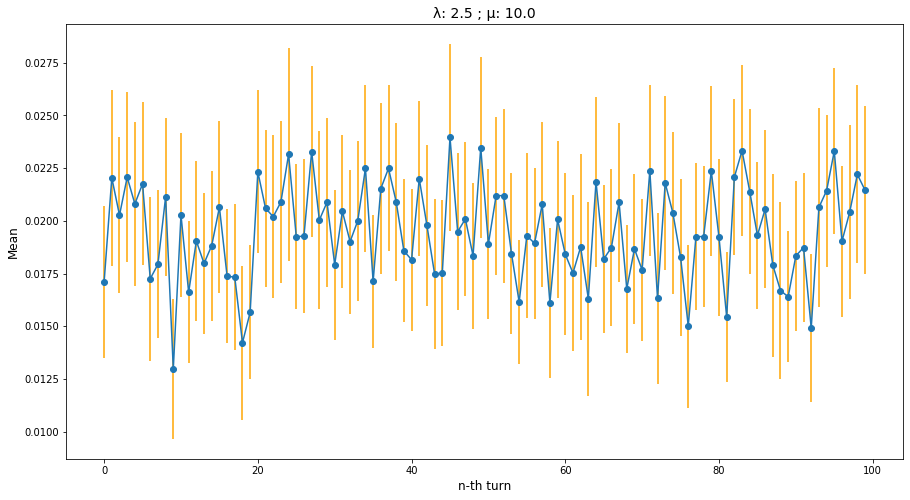

In [71]:
fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

In [72]:
theoric_value = get_mean_waiting_theoric(lambda_,mi)
contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

For λ: 2.5 and μ: 10.0, the theoric value is 0.03333333333333333
The coverage of the confidence interval containing the theoric value is 0.0


### Traffic intensity 50% (λ: 5.0 ; μ: 10.0)

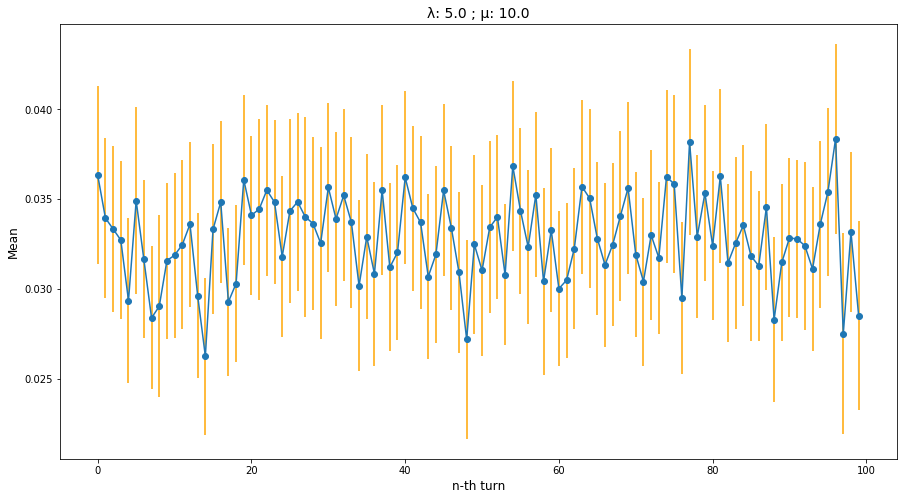

For λ: 5.0 and μ: 10.0, the theoric value is 0.1
The coverage of the confidence interval containing the theoric value is 0.0


In [73]:
turns = []
running_times = 100
lambda_ = 5.0
mi = 10.0
n = 1000

for _ in range(running_times):
    turn = {}
    times_queue = simulate_queue(lambda_, mi, n)
    eliminated_transient = mser(times_queue)
    turn['confidence_interval'] = confidence_interval(eliminated_transient, 0.95)
    turn['mean'] = arithmetic_average(eliminated_transient)
    turn['nbm'] = nbm(eliminated_transient)
    turns.append(turn)
    
nbm_turn = {}
nbm_turn['traffic'] = lambda_ / mi
nbm_turn['coverage'] = sum([turn['nbm'] for turn in turns]) / running_times
nbm_by_turn.append(nbm_turn)

x = [i for i in range(running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]
errors = [(fabs(y[i]-errors[i][0]), fabs(y[i]-errors[i][1])) for i in range(len(errors))]
errors = [list(i) for i in zip(*errors)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

theoric_value = get_mean_waiting_theoric(lambda_,mi)
contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

### Traffic intensity 75% (λ: 7.5 ; μ: 10.0)

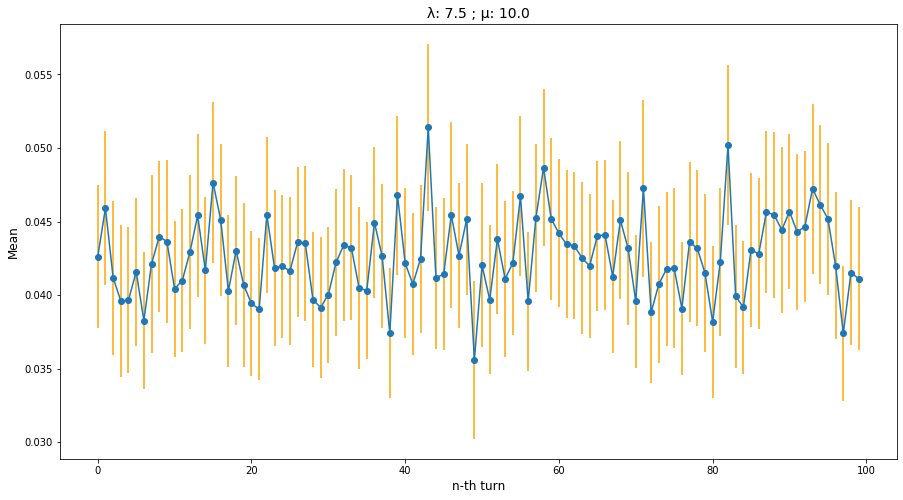

For λ: 7.5 and μ: 10.0, the theoric value is 0.3
The coverage of the confidence interval containing the theoric value is 0.0


In [74]:
turns = []
running_times = 100
lambda_ = 7.5
mi = 10.0
n = 1000

for _ in range(running_times):
    turn = {}
    times_queue = simulate_queue(lambda_, mi, n)
    eliminated_transient = mser(times_queue)
    turn['confidence_interval'] = confidence_interval(eliminated_transient, 0.95)
    turn['mean'] = arithmetic_average(eliminated_transient)
    turn['nbm'] = nbm(eliminated_transient)
    turns.append(turn)
    
nbm_turn = {}
nbm_turn['traffic'] = lambda_ / mi
nbm_turn['coverage'] = sum([turn['nbm'] for turn in turns]) / running_times
nbm_by_turn.append(nbm_turn)

x = [i for i in range(running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]
errors = [(fabs(y[i]-errors[i][0]), fabs(y[i]-errors[i][1])) for i in range(len(errors))]
errors = [list(i) for i in zip(*errors)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

theoric_value = get_mean_waiting_theoric(lambda_,mi)
contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

### Traffic intensity 90% (λ: 9.0 ; μ: 10.0)

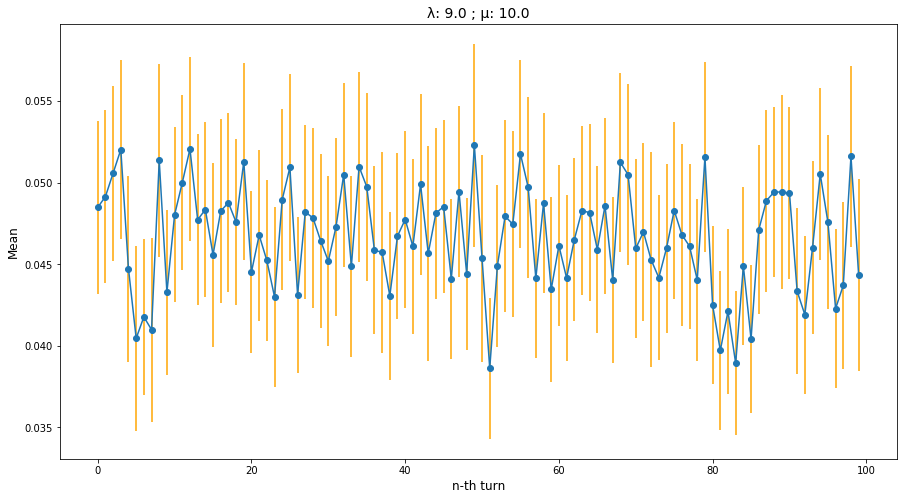

For λ: 9.0 and μ: 10.0, the theoric value is 0.9000000000000002
The coverage of the confidence interval containing the theoric value is 0.0


In [75]:
turns = []
running_times = 100
lambda_ = 9.0
mi = 10.0
n = 1000

for _ in range(running_times):
    turn = {}
    times_queue = simulate_queue(lambda_, mi, n)
    eliminated_transient = mser(times_queue)
    turn['confidence_interval'] = confidence_interval(eliminated_transient, 0.95)
    turn['mean'] = arithmetic_average(eliminated_transient)
    turn['nbm'] = nbm(eliminated_transient)
    turns.append(turn)
    
nbm_turn = {}
nbm_turn['traffic'] = lambda_ / mi
nbm_turn['coverage'] = sum([turn['nbm'] for turn in turns]) / running_times
nbm_by_turn.append(nbm_turn)

x = [i for i in range(running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]
errors = [(fabs(y[i]-errors[i][0]), fabs(y[i]-errors[i][1])) for i in range(len(errors))]
errors = [list(i) for i in zip(*errors)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

theoric_value = get_mean_waiting_theoric(lambda_,mi)
contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

### Traffic intensity 95% (λ: 9.5 ; μ: 10.0)

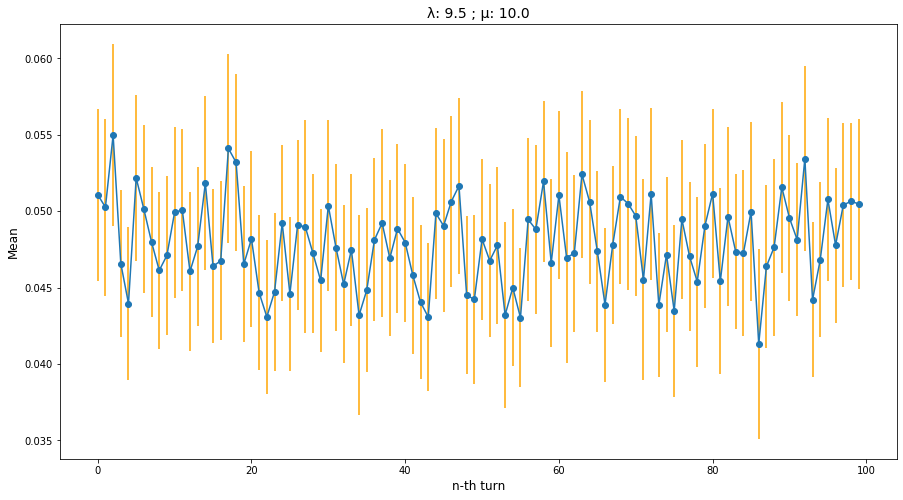

For λ: 9.5 and μ: 10.0, the theoric value is 1.8999999999999981
The coverage of the confidence interval containing the theoric value is 0.0


In [76]:
turns = []
running_times = 100
lambda_ = 9.5
mi = 10.0
n = 1000

for _ in range(running_times):
    turn = {}
    times_queue = simulate_queue(lambda_, mi, n)
    eliminated_transient = mser(times_queue)
    turn['confidence_interval'] = confidence_interval(eliminated_transient, 0.95)
    turn['mean'] = arithmetic_average(eliminated_transient)
    turn['nbm'] = nbm(eliminated_transient)
    turns.append(turn)
    
nbm_turn = {}
nbm_turn['traffic'] = lambda_ / mi
nbm_turn['coverage'] = sum([turn['nbm'] for turn in turns]) / running_times
nbm_by_turn.append(nbm_turn)

x = [i for i in range(running_times)]
y = [turn['mean'] for turn in turns]
errors = [turn['confidence_interval'] for turn in turns]
errors = [(fabs(y[i]-errors[i][0]), fabs(y[i]-errors[i][1])) for i in range(len(errors))]
errors = [list(i) for i in zip(*errors)]

fig,ax = plt.subplots(figsize=(15, 8))
plt.title(f'λ: {lambda_} ; μ: {mi}', fontsize=14)
ax.errorbar(x,y,yerr=errors, fmt='-o', ecolor='orange')
plt.xlabel('n-th turn', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.show()

theoric_value = get_mean_waiting_theoric(lambda_,mi)
contains_percent_value = get_contains_percent_value(turns, theoric_value)

print(f'For λ: {lambda_} and μ: {mi}, the theoric value is {theoric_value}')
print(f'The coverage of the confidence interval containing the theoric value is {contains_percent_value}')

### Coverage NBM

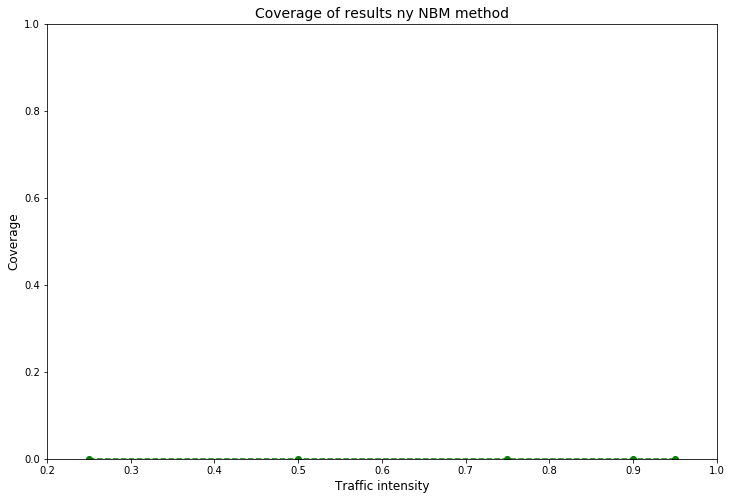

In [78]:
plt.figure(figsize=(12,8))
plt.plot([turn['traffic'] for turn in nbm_by_turn], [turn['coverage'] for turn in nbm_by_turn], 'go--')
plt.title('Coverage of results ny NBM method', fontsize=14)
plt.xlabel('Traffic intensity', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.xlim(0.2, 1)
plt.ylim(0, 1)
plt.show()